In [1]:
from bitarray import bitarray
import mmh3
import random
import numpy as np
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
from sklearn.datasets import load_wine

In [5]:
x , y = load_wine(return_X_y=True)

In [6]:
print(x)
print(y)
print(x.shape)
print(y.shape)
input_dim = x.shape[1]
print(input_dim)

[[1.423e+01 1.710e+00 2.430e+00 ... 1.040e+00 3.920e+00 1.065e+03]
 [1.320e+01 1.780e+00 2.140e+00 ... 1.050e+00 3.400e+00 1.050e+03]
 [1.316e+01 2.360e+00 2.670e+00 ... 1.030e+00 3.170e+00 1.185e+03]
 ...
 [1.327e+01 4.280e+00 2.260e+00 ... 5.900e-01 1.560e+00 8.350e+02]
 [1.317e+01 2.590e+00 2.370e+00 ... 6.000e-01 1.620e+00 8.400e+02]
 [1.413e+01 4.100e+00 2.740e+00 ... 6.100e-01 1.600e+00 5.600e+02]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
(178, 13)
(178,)
13


In [7]:
y[y==1] = 0
y[y==2] = 1

In [8]:
x_train = np.array(x)
y_train = np.array(y.reshape(-1,1))

In [9]:
additional_metrics = ['acc']
loss_function = BinaryCrossentropy()
number_of_epochs = 5000
optimizer = Adam()
verbosity_mode = 0
layer_size = 1

In [10]:
model = Sequential()
model.add(Dense(layer_size,input_dim=input_dim,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [11]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 14        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


In [13]:
x_train = StandardScaler().fit_transform(x_train)

## Model training

In [14]:
batch_size = len(x_train)

In [15]:
history = model.fit(x_train, y_train, batch_size = batch_size, epochs=number_of_epochs, verbose=verbosity_mode)

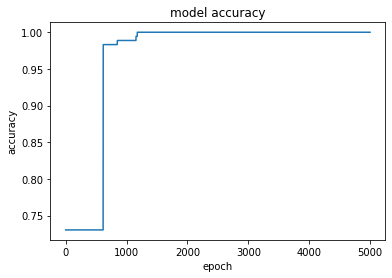

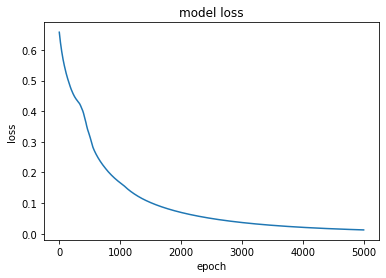

In [16]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

#Hidden Layer Size=1

In [17]:
class BloomFilter:
    
    def __init__(self, size, model): #hash count is 1
        self.size = size
      #  self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        self.model=model #classifier model associated as hash function
        
    def add(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(model.predict(num)[0]*(self.size-1))    
        self.bit_array[result] = 1
            
    def lookup(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(self.model.predict(num)[0]*(self.size-1))    
        if self.bit_array[result] == 0:
                return False
        return True

    def add_init(self,x_train,y_train):
        pred = self.model.predict(x_train)
        for i in range(len(pred)):
            if(y_train[i]==1):
                result = math.floor(pred[i][0]*(self.size-1))
                self.bit_array[result] = 1

    def predict(self,x):
        initpred = self.model.predict(x)
        indexes = []
        for i in range(len(initpred)):
            indexes += [math.floor(initpred[i][0]*(bf.size-1))]
        pred = []
        for i in indexes:
            pred += [self.bit_array[i]]
        return np.array(pred)

#adds ratio r of an array of random integers of size n to bloom filter bf(input : bf,size,ratio; output: data array)
def addrandom(bf,n,r):
    data=np.empty(n,dtype=int)
    for i in range(0,n):
        data[i]=random.randint(0, 100000000)
    for j in range(0,int(n*r)):
        bf.add(data[j])
    return data

#(Input:bloom filter,number array,ratio of positives; Output:(-1) for false negative, otherwise fpr)
def fpr_kraska_hash(bf,nums):
    pred = bf.predict(x_train)
    tn, fp, fn, tp = confusion_matrix(y_train, pred).ravel() 
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

#(Input:size of bloom filter, number of hash functions, total numbers, ratio of numbers inserted; Output: fpr)
def find_fpr(m,model,n,r):
    bf=BloomFilter(model,m)
    data=addrandom(bf,n,r)
    return fpr(bf,data,r)

#(Input:size of bloom filter, total numbers, ratio of numbers inserted; Output: prints inputs and fpr)
def outputs(m,n,r):
    find_fpr(m,model,n,r)
    #print("For m=%d, k=%d, n=%d, r=%.3f: fpr=%.3f"%(m,k,n,r,find_fpr(m,k,n,r)))

In [18]:
m = 3

In [19]:
bf=BloomFilter(m,model)

In [20]:
bf.add_init(x_train,y_train)

In [21]:
pred = bf.predict(x_train)

tn, fp, fn, tp = confusion_matrix(y_train, pred).ravel() 
print(tn)
print(tp)
print(fp)
print(fn)

130
48
0
0


In [22]:
print(fpr_kraska_hash(bf,x_train))

0.0
